EDA & Text Preprocessing:

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiongjieliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


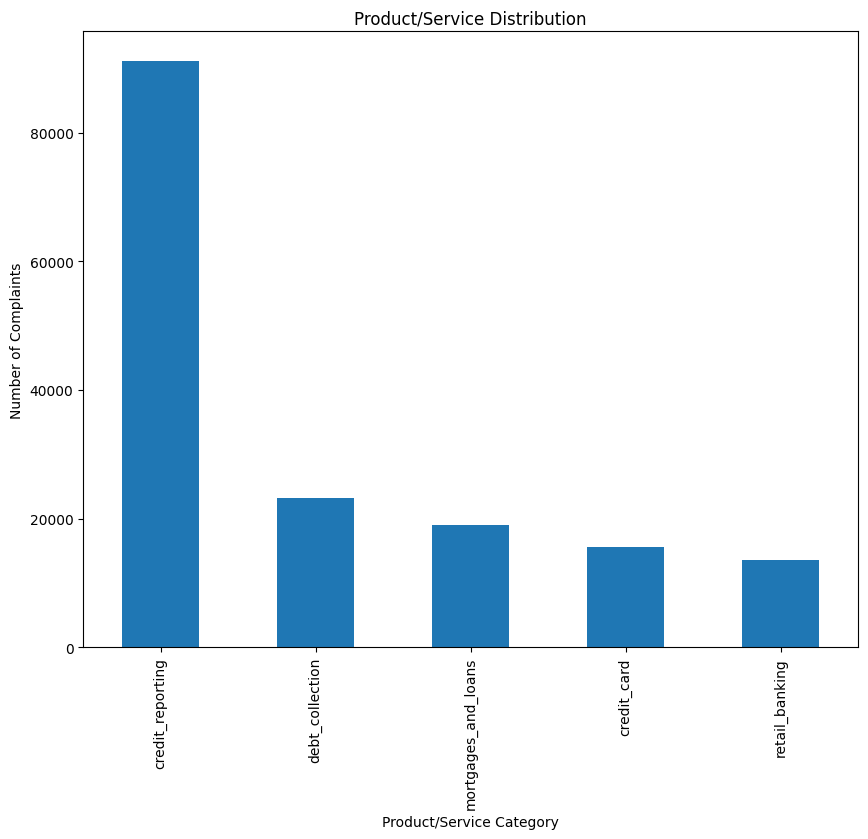

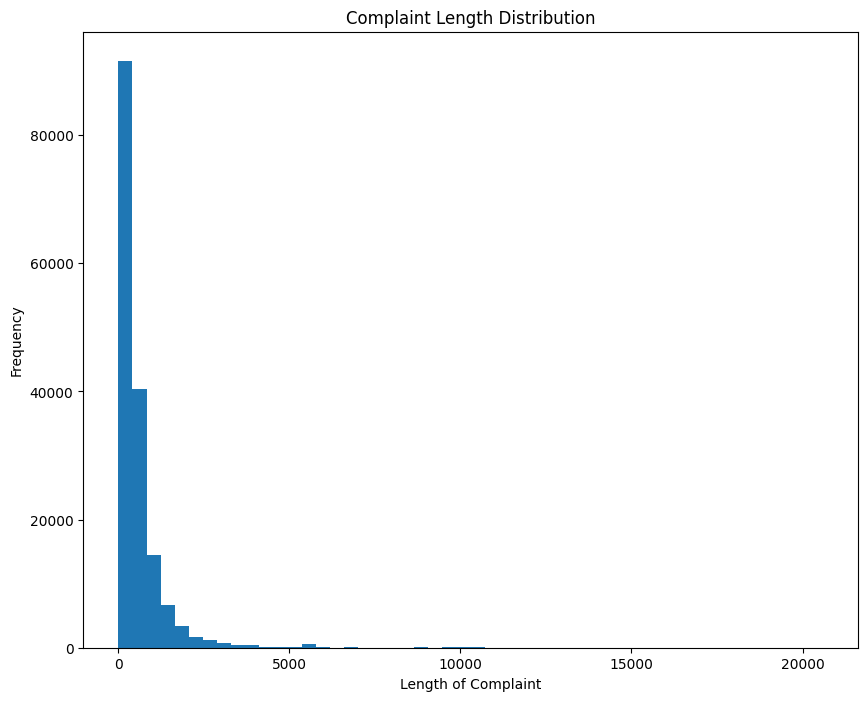

处理后的数据已保存到 processed_complaints.csv


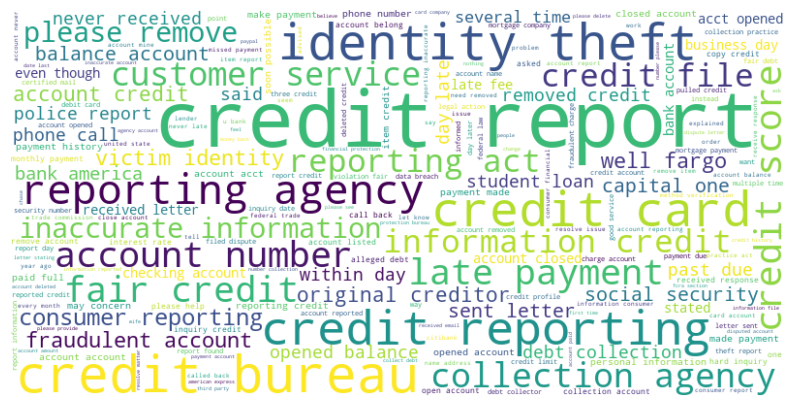

Training set size: 129928
Testing set size: 32483


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk

#download stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# load the dataset
df = pd.read_csv(r'/Users/jiongjieliu/Documents/Meng/2024Winter/Applied Machine Learning/Assignment 2/complaints.csv')

# Delete irrelevant columns or entries and handle missing or null values 
df = df[['complaint_no', 'product','narrative']]  # Retain key columns
df.dropna(inplace=True)  # Delete rows containing null values

# Explore the distribution of products/services in the dataset
product_distribution = df['product'].value_counts()
plt.figure(figsize=(10, 8))
product_distribution.plot(kind='bar')
plt.title('Product/Service Distribution')
plt.xlabel('Product/Service Category')
plt.ylabel('Number of Complaints')
plt.show()

# Analyze the length distribution of client narratives
df['complaint_length'] = df['narrative'].apply(len)
plt.figure(figsize=(10, 8))
plt.hist(df['complaint_length'], bins=50)
plt.title('Complaint Length Distribution')
plt.xlabel('Length of Complaint')
plt.ylabel('Frequency')
plt.show()

# Text pre-processing
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = text.lower()  # Lowercase it
    text = re.sub(r'\[.*?\]', '', text)  # Remove bracketed text
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text)  # Replace double spaces with single spaces
    tokens = word_tokenize(text)  # Split the word
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return ' '.join(tokens)

df['processed_complaint'] = df['narrative'].apply(preprocess_text)
# Save processed data to a CSV file
processed_file_path = 'processed_complaints.csv'
df.to_csv(processed_file_path, index=False)

print(f'处理后的数据已保存到 {processed_file_path}')



# Identify the most common words or phrases used in the narrative
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(df['processed_complaint']))
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Prepare coded labels for training
le = LabelEncoder()
df['product_category_encoded'] = le.fit_transform(df['product'])


# Split the dataset into training and validation sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(df['processed_complaint'], df['product_category_encoded'], test_size=0.2, random_state=42)

# Output training and test set sizes to confirm segmentation
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

In [1]:
#Split the dataset into training and validation sets
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the preprocessed dataset
df = pd.read_csv('processed_complaints.csv')

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2)

# Export the training and testing sets to CSV files
train_df.to_csv('train_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)

print("Training and testing datasets have been exported successfully.")


Training and testing datasets have been exported successfully.


In [18]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv(r'/Users/jiongjieliu/Documents/Meng/2024Winter/Applied Machine Learning/Assignment 2/train_dataset.csv')

# Prepare input and output vectors
X = df['processed_complaint'].values
y = df['product'].values  # Assuming 'product' is the column you want to predict

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Find the maximum length from both training and validation sequences
max_length = max(max([len(x) for x in X_train_seq]), max([len(x) for x in X_val_seq]))

# Padding sequences to have the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# Define the model architecture with some changes
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),  # Set correct input_length
    Bidirectional(LSTM(128, return_sequences=True)),  # Increased LSTM units
    Dropout(0.5),  # Adjusted dropout rate
    Bidirectional(LSTM(64)),  # Changed LSTM units
    Dense(128, activation='relu'),  # Increased number of neurons
    Dropout(0.5),  # Adjusted dropout rate
    Dense(len(np.unique(y_encoded)), activation='softmax')  # Output layer
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=legacy.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_pad, y_train,
                    epochs=30,  # Increased the number of epochs
                    batch_size=64,  # Decreased batch size for potentially better generalization
                    validation_data=(X_val_pad, y_val),
                    callbacks=[early_stopping])  # Added early stopping callback

# Summarize the model architecture
model.summary()

# Save the model
model.save(r'/Users/jiongjieliu/Documents/Meng/2024Winter/Applied Machine Learning/Assignment 2/bi_lstm_model.h5')  # Updated save path


Epoch 1/30
2031/2031 [==============================] - 13393s 7s/step - loss: 0.4910 - accuracy: 0.8331 - val_loss: 0.3913 - val_accuracy: 0.8643
Epoch 2/30
2031/2031 [==============================] - 13609s 7s/step - loss: 0.3663 - accuracy: 0.8773 - val_loss: 0.3578 - val_accuracy: 0.8784
Epoch 3/30
2031/2031 [==============================] - 12695s 6s/step - loss: 0.3287 - accuracy: 0.8896 - val_loss: 0.3543 - val_accuracy: 0.8756
Epoch 4/30
2031/2031 [==============================] - 12629s 6s/step - loss: 0.2940 - accuracy: 0.9002 - val_loss: 0.3578 - val_accuracy: 0.8790
Epoch 5/30
2031/2031 [==============================] - 13052s 6s/step - loss: 0.2675 - accuracy: 0.9097 - val_loss: 0.3536 - val_accuracy: 0.8810
Epoch 6/30
2031/2031 [==============================] - 12705s 6s/step - loss: 0.2402 - accuracy: 0.9181 - val_loss: 0.3618 - val_accuracy: 0.8827
Epoch 7/30
2031/2031 [==============================] - 13102s 6s/step - loss: 0.2139 - accuracy: 0.9266 - val_loss: 0

/Library/Python/3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


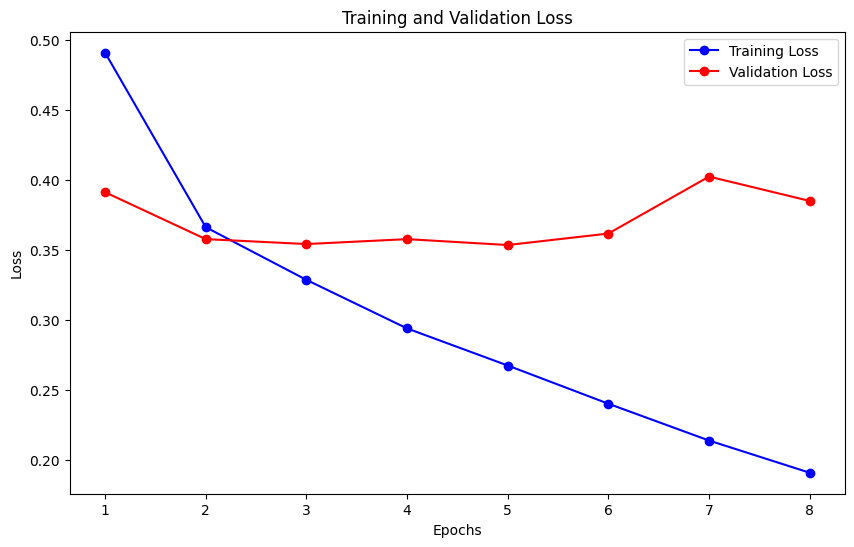

In [1]:
import matplotlib.pyplot as plt

# Training and validation loss values
training_loss = [0.4910, 0.3663, 0.3287, 0.2940, 0.2675, 0.2402, 0.2139, 0.1909]
validation_loss = [0.3913, 0.3578, 0.3543, 0.3578, 0.3536, 0.3618, 0.4025, 0.3851]

epochs = range(1, len(training_loss) + 1)

# Plotting the loss graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



This chart illustrates the training and validation loss of a machine learning model over multiple epochs. The horizontal axis represents the number of epochs, which are iterations over the training dataset. The vertical axis shows the loss, a measure of the model's prediction error, with lower values indicating better performance.

As the epochs increase, the training loss (depicted by the blue line) consistently decreases, suggesting that the model is improving its performance on the training data, which is an expected outcome during the learning process.

However, the validation loss (represented by the red line) initially decreases but then starts to rise after the 5th epoch. This could be an indication of overfitting, where the model performs very well on the training data but fails to generalize to new, unseen data, leading to a degradation in performance.

1016/1016 [==============================] - 913s 898ms/step
Accuracy: 0.6163531693501216
Precision: 0.5809385603973439
Recall: 0.6163531693501216
F1 Score: 0.5883695872909379


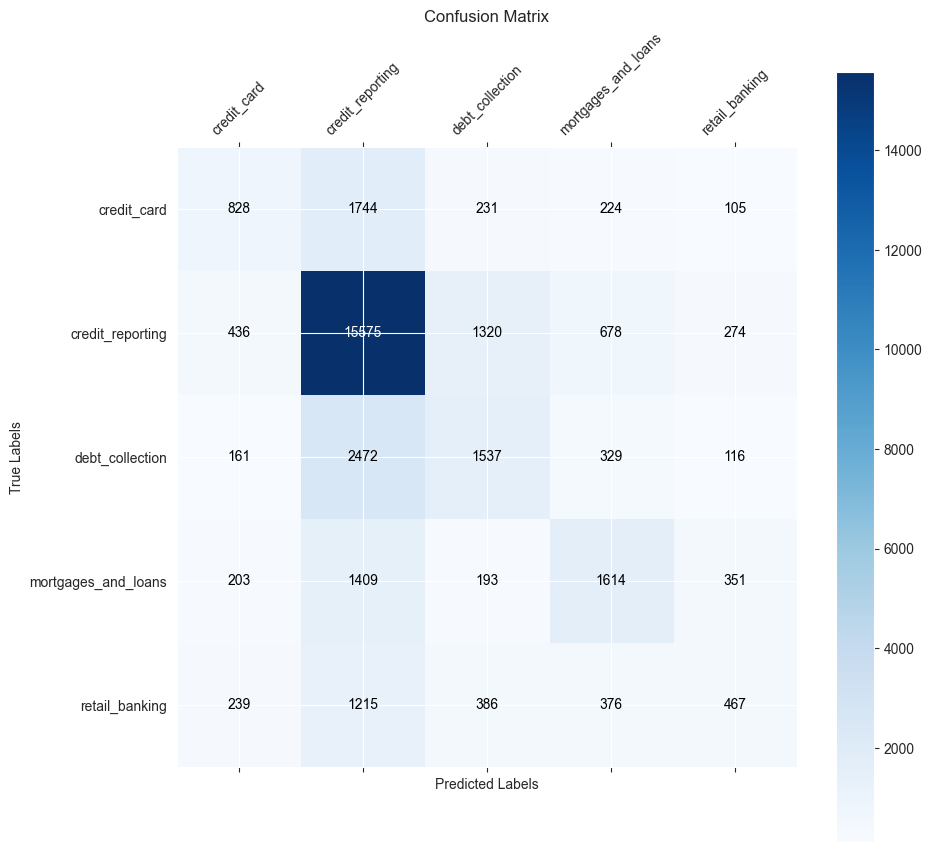

In [3]:
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset
test_df = pd.read_csv(r'/Users/jiongjieliu/Documents/Meng/2024Winter/Applied Machine Learning/Assignment 2/test_dataset.csv')

# Assuming 'narrative' and 'product' are your input and output columns
X_test = test_df['processed_complaint'].values
y_test = test_df['product'].values

# Initialize and fit LabelEncoder on your test labels (for demonstration)
# In practice, load your trained LabelEncoder here
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Initialize and fit Tokenizer on your test data (for demonstration)
# In practice, load your trained Tokenizer here
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_test)  # For demonstration; in practice, you should not fit it here
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Correct max_length to match the model's expected input length
max_length = 2684

# Padding sequences
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Continue with loading the model and making predictions
model_path = '/Users/jiongjieliu/Documents/Meng/2024Winter/Applied Machine Learning/Assignment 2/bi_lstm_model.h5'  
model = load_model(model_path)

# Predict on the test set
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate and print metrics
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
precision = precision_score(y_test_encoded, y_pred_classes, average='weighted')
recall = recall_score(y_test_encoded, y_pred_classes, average='weighted')
f1 = f1_score(y_test_encoded, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Generate and visualize confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_classes)
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add colorbar
fig.colorbar(cax)

# Add labels to each axis, adjusting for Python's 0-based indexing
classes = label_encoder.classes_
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

# Label each cell with the counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), 
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()


Naive Bayes Evaluation:
Accuracy: 0.8365606625003849
Precision: 0.835305508612474
Recall: 0.8365606625003849
F1 Score: 0.8325423727316777


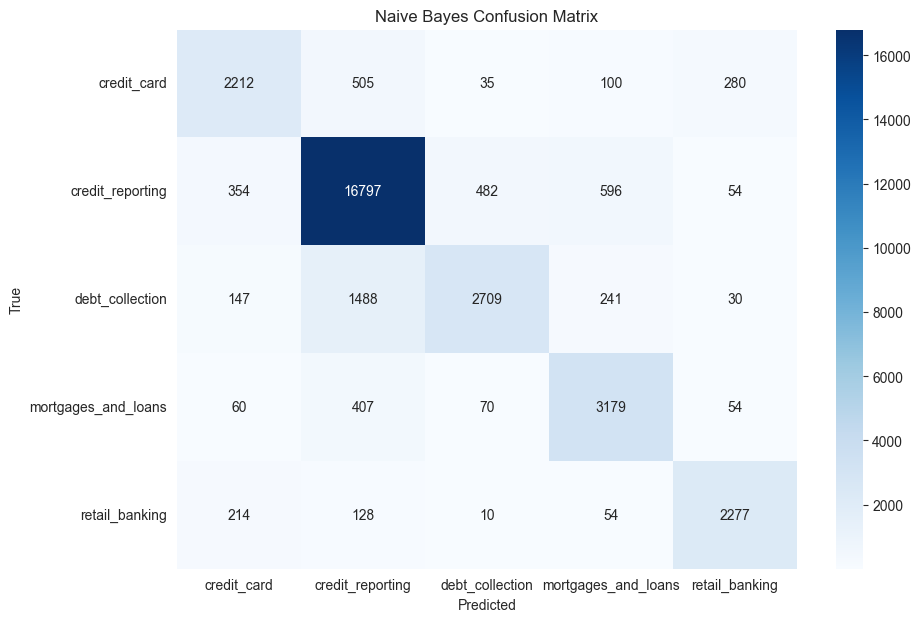

Random Forest Evaluation:
Accuracy: 0.8811686112735893
Precision: 0.8802619934180708
Recall: 0.8811686112735893
F1 Score: 0.8774865065317645


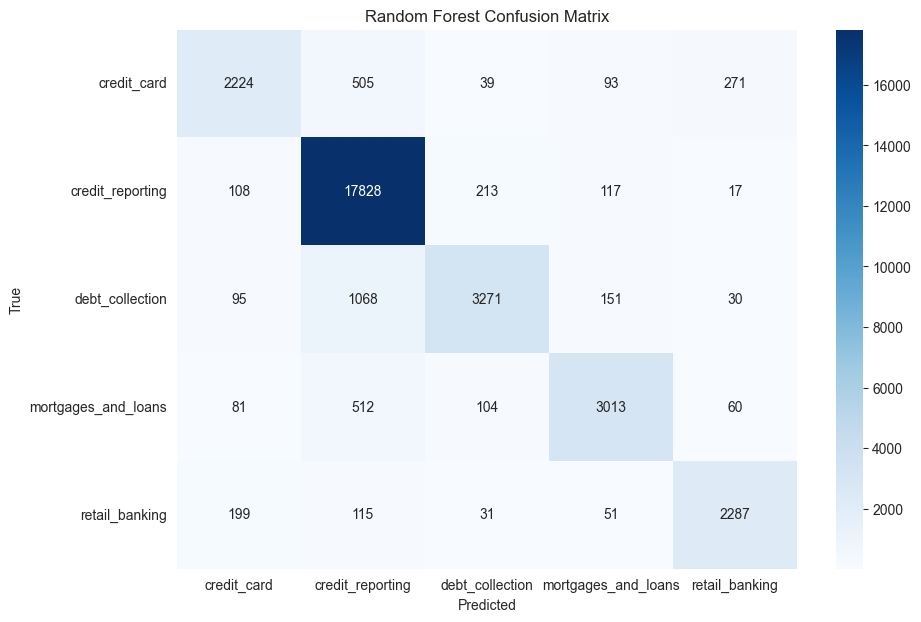

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
 
# Load training and testing datasets
train_df = pd.read_csv('train_dataset.csv')  # Load the training dataset
test_df = pd.read_csv('test_dataset.csv')    # Load the testing dataset
 
X_train = train_df['processed_complaint']    # Replace with your text feature column name
y_train = train_df['product']                # Replace with your label column name
 
X_test = test_df['processed_complaint']      # Replace with your text feature column name
y_test = test_df['product']                  # Replace with your label column name

# Label encoding to ensure the labels are properly formatted for visualization
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
 
# Text vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
 
# Train Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_encoded)
 
# Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train_encoded)
 
# Define evaluation function
def evaluate_model(model, X_test, y_test_encoded, labels, model_name="Model"):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)   # Calculate accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='weighted')  # Calculate precision, recall, and F1 score
    conf_mat = confusion_matrix(y_test_encoded, y_pred) # Generate confusion matrix
    print(f"{model_name} Evaluation:")   # Print model evaluation results
    print(f"Accuracy: {accuracy}")       # Print accuracy
    print(f"Precision: {precision}")     # Print precision
    print(f"Recall: {recall}")           # Print recall
    print(f"F1 Score: {f1}")             # Print F1 score
    plt.figure(figsize=(10, 7))          # Set figure size for heatmap
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)   # Generate heatmap for confusion matrix
    plt.title(f"{model_name} Confusion Matrix")   # Set title for the plot
    plt.xlabel('Predicted')                         # Set label for x-axis
    plt.ylabel('True')                              # Set label for y-axis
    plt.show()                                      # Show plot
 
# Extract the class labels for use in the confusion matrix
class_labels = label_encoder.classes_

# Evaluate Naive Bayes classifier
evaluate_model(nb_model, X_test_tfidf, y_test_encoded, class_labels, model_name="Naive Bayes")
 
# Evaluate Random Forest classifier
evaluate_model(rf_model, X_test_tfidf, y_test_encoded, class_labels, model_name="Random Forest")


Bi-LSTM Model
Confusion Matrix Observations: The confusion matrix shows some notable confusions between classes, particularly between 'credit_reporting' and 'debt_collection' which could indicate similarities in the textual patterns of these two classes that the model is picking up on. While the model performs reasonably well in identifying 'credit_reporting', it has notable confusion in other classes.

Metrics:
Accuracy: 61.6% - This is moderately high, suggesting the model is correct around 3 out of 5 times.
Precision: 58.1% - On average, when the model predicts a class, it is correct 58.1% of the time.
Recall: 61.6% - The model has the same score for recall as accuracy, indicating that it has a moderate ability to find all the positive samples.
F1 Score: 58.8% - The F1 score is close to the precision, showing a balance between precision and recall but at a moderate level.


Naive Bayes Model
Confusion Matrix Observations: The Naive Bayes model's confusion matrix indicates better performance, with high correct predictions for 'credit_reporting'. However, it still has some confusion between 'credit_card' and 'credit_reporting'.

Metrics:
Accuracy: 83.7% - This shows a significant improvement over the Bi-LSTM model.
Precision: 83.5% - This model is more reliable in its predictions than the Bi-LSTM.
Recall: 83.7% - It is also more capable of finding all the positive samples.
F1 Score: 83.3% - A high F1 score indicates a good balance between precision and recall.


Random Forest Model
Confusion Matrix Observations: The Random Forest confusion matrix shows the highest number of correct predictions on the diagonal, indicating a strong performance across classes, with relatively fewer misclassifications than the other models.

Metrics:
Accuracy: 88.1% - This is the highest accuracy among the three models, indicating that it correctly predicts the class 88.1% of the time.
Precision: 88.0% - It suggests that when the model predicts something, it is correct 88% of the time.
Recall: 88.1% - This model has a high ability to find all positive samples.
F1 Score: 87.7% - A very high F1 score shows an excellent balance between precision and recall.


Summary
The Random Forest model outperforms both the Bi-LSTM and Naive Bayes models in all metrics, indicating it is the most reliable for this classification task based on the given data. Naive Bayes, despite being a simpler model, also shows strong performance, especially in comparison to the Bi-LSTM model. The Bi-LSTM's performance is notably lower, which could be due to various reasons including the need for more data, tuning, or inherent limitations in modeling the patterns present in the data. However, in practice, decisions on model selection should also consider other factors such as training time, interpretability, and how the model will be used in production.

Part B: Performance Evaluation
1)The model to be considered for final deployment would typically be Model B since it performs better on unseen data (validation data), suggesting it may generalize better to new data.

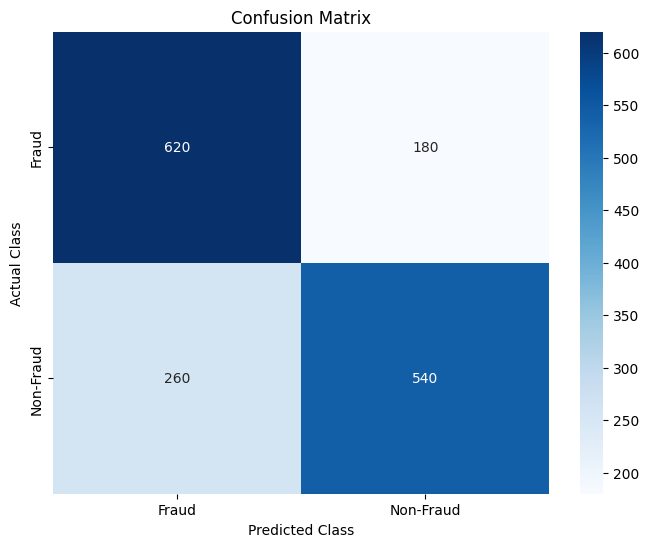

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for confusion matrix
confusion_matrix = np.array([
    [620, 180],
    [260, 540]
])

# Labels for the axes
labels = ['Fraud', 'Non-Fraud']

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Adding aesthetics
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


b. After adjusting for oversampling to a total of 10,000 examples, where it's assumed that 98% of the claims are non-fraudulent and 2% are fraudulent, the calculations for the confusion matrix elements are as follows:

True Negatives (TN) are recalculated based on the proportion of non-fraudulent claims and the initial model's performance. Given 10,000 examples, the true negatives amount to 10000*0.98*540/(540+260)=6615

False Positives (FP) are the remaining non-fraudulent cases after subtracting the true negatives from the total non-fraudulent claims, resulting in 10000*0.98-TN=3185

False Negatives (FN) are recalculated similarly, based on the proportion of fraudulent claims, yielding 10000*0.02*180/(180+620)=45

True Positives (TP) are the remaining fraudulent cases after subtracting false negatives from the total fraudulent claims, which gives 10000*0.02-FN=155

The misclassification rate is(45+3185)/10000=32.3%

c. The expected percentage of new records classified as fraudulent is computed by adding the false positives (incorrectly classified as fraudulent) and the true positives (correctly identified frauds), then dividing by the total number of records. This results in (3185+155)/10000=33.4%

Thus, after adjusting for oversampling, the adjusted misclassification rate is 32.3%, and the expected percentage of new records classified as fraudulent is 33.4%.
